In [1]:
"""
===========================================================
Using PyPARRM to filter out stimulation artefacts from data
===========================================================

This example demonstrates how the PARRM algorithm :footcite:`DastinEtAl2021`
can be used to identify and remove stimulation artefacts from
electrophysiological data in the PyPARRM package.
"""

import numpy as np
import cupy as cp
from matplotlib import pyplot as plt

import sys
import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

sys.path.append('../../../../existing_SAC/PARRM/PyPARRM-main/src/pyparrm')

from parrm import PARRM
from _utils._power import compute_psd

fpath='../../../../data/synthetic_data/'
# fpath = 'C:/Users/User/Desktop/SCH/paper_data/'
Contaminated = np.load(fpath + "contaminated_by_realistic" + ".npy")
Clean = np.load(fpath + "clean_data" + ".npy")
Contaminated = Contaminated[0:3]
Clean = Clean[0:3]

c:\Users\User\anaconda3\envs\torch1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fs = 2000  # Hz
artefact_freq = 130  # Hz

winTime = 0.8
skipTime = winTime / 10
perDist = 0.01

# winTime = 0.5 
# skipTime = winTime / 10  
# perDist = 0.01

winSize = int(fs*winTime)  
skipSize = int(fs*skipTime)
winDir = "both"

print(
    f"`data` has shape: ({Contaminated.shape[0]} channel, "
    f"{Contaminated.shape[1]} timepoints)\n"
    f"`data` duration: {Contaminated.shape[1] / fs :.2f} seconds"
)

`data` has shape: (3 channel, 4000 timepoints)
`data` duration: 2.00 seconds


In [3]:
parrmed = []

for i in range(Contaminated.shape[0]):
    parrm = PARRM(
        data=Contaminated[i].reshape(1, -1),
        sampling_freq=fs,
        artefact_freq=artefact_freq,
        verbose=False,  # silenced to reduce pqdm output clutter
    )

    parrm.find_period()

    print(f"Sample : {i} | Estimated artefact period: {parrm.period :.4f}")

    parrm.create_filter(
        filter_half_width=winSize,
        omit_n_samples=skipSize,
        filter_direction=winDir,
        period_half_width=perDist,
    )
    parrmed_data = parrm.filter_data()  # other data to filter can be given here
    parrmed.append(parrmed_data)


Sample : 0 | Estimated artefact period: 15.9996
Sample : 1 | Estimated artefact period: 16.0000
Sample : 2 | Estimated artefact period: 15.9999


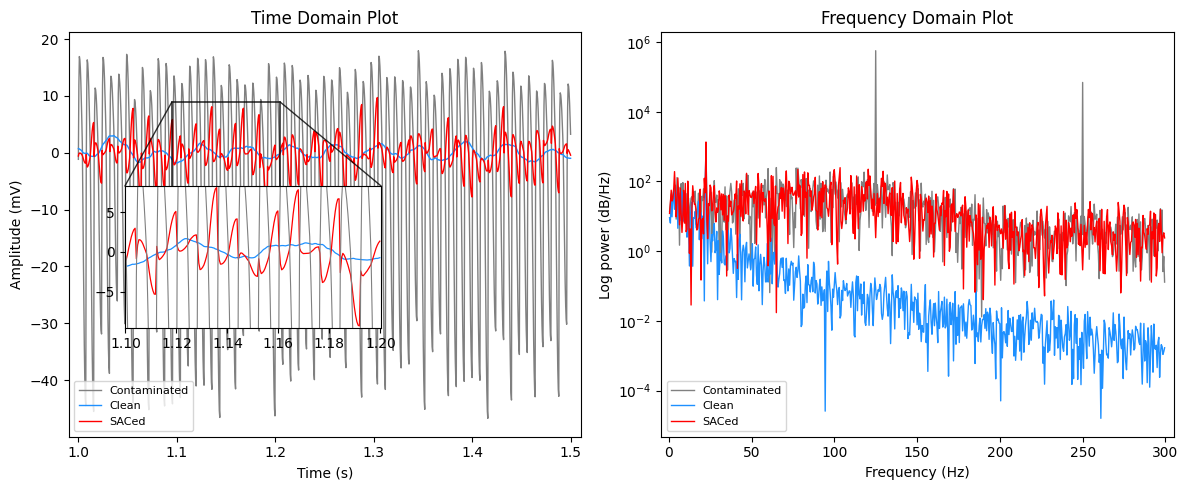

< MSE >
Time Domain MSE: 8.89519480689964 ± 0.0
Frequency Domain MSE: 668.0122113869378 ± 0.0


In [4]:
save_path = '../../../../result/paper/'
save_title = 'PARRM'
Result_Plot(Contaminated, parrmed_data, Clean)
# Result_Plot_paper(Contaminated, parrmed_data, Clean, save_path, save_title)